In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf




In [2]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Import Data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print("Train size:{}\nTest size:{}".format(train.shape, test.shape))

# Transform Train and Test into images\labels.
x_train = train.drop(['label'], axis=1).values.astype('float32') # all pixel values
y_train = train['label'].values.astype('int32') # only labels i.e targets digits
x_test = test.values.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28) / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28) / 255.0

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.11, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(x_test.shape)

Train size:(42000, 785)
Test size:(28000, 784)
(37380, 28, 28)
(4620, 28, 28)
(37380,)
(28000, 28, 28)


In [3]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)  
x_val = x_val.reshape(x_val.shape[0], 28, 28,1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28,1) 
print("Train size:{}\nvalidation size:{}\nTest size:{}".format(x_train.shape,x_val.shape, x_test.shape))

mean_px = x_train.mean().astype(np.float32)
std_px = x_train.std().astype(np.float32)


Train size:(37380, 28, 28, 1)
validation size:(4620, 28, 28, 1)
Test size:(28000, 28, 28, 1)


In [4]:
from tensorflow.python.keras.layers import Input , Dense , Conv2D , Activation , Add,ReLU,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.python.keras.models import Model



input = Input(shape=[28, 28, 1])
x = Conv2D(32, (5, 5), strides=1, padding='same')(input)
# x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)
x = Conv2D(32, (5, 5), strides=1, padding='same')(x)
# x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x = Dropout (0.2)(x)

x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
# x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)
x = Dropout (0.5)(x)
x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
# x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), strides=1, padding='same')(x)
# x = BatchNormalization(momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
x = Activation('relu')(x)

x = MaxPool2D(pool_size=2, strides=2, padding='same')(x)
x = Dropout (0.2)(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dense(10)(x)
x = Activation('softmax')(x)

model = Model(inputs = input, outputs =x)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPoo

In [5]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.keras.optimizers import Adam ,RMSprop


# optimizer = RMSprop(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0)
epochs = 50
Learning_rate = 0.001
decay= 5 * Learning_rate / epochs
# optimizer = Adam(lr=Learning_rate, decay= 3 * Learning_rate / epochs)
optimizer = RMSprop(lr=Learning_rate, rho=0.9, epsilon=1e-08, decay= 0)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#               loss='sparse_categorical_crossentropy',

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=0.0001)

# Data augmentation
aug_num = 11 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= aug_num,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = aug_num / 100, # Randomly zoom image 
        width_shift_range= aug_num / 100,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= aug_num / 100,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically


datagen.fit(x_train)
# batch_size = 64
batch_size = 256
# Max value lr_min = 0.000125
checkpoint = ModelCheckpoint("best_weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 0, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[checkpoint,learning_rate_reduction])
model.load_weights("best_weights.hdf5") 


Instructions for updating:
Use tf.cast instead.
4620/4620 [==============================] - 0s 55us/sample - loss: 0.3820 - acc: 0.9723

Epoch 00001: val_acc improved from -inf to 0.97229, saving model to best_weights.hdf5
4620/4620 [==============================] - 0s 25us/sample - loss: 0.2297 - acc: 0.9314

Epoch 00002: val_acc did not improve from 0.97229
4620/4620 [==============================] - 0s 31us/sample - loss: 0.0511 - acc: 0.9855

Epoch 00003: val_acc improved from 0.97229 to 0.98550, saving model to best_weights.hdf5
4620/4620 [==============================] - 0s 30us/sample - loss: 0.0547 - acc: 0.9855

Epoch 00004: val_acc did not improve from 0.98550
4620/4620 [==============================] - 0s 30us/sample - loss: 0.0335 - acc: 0.9903

Epoch 00005: val_acc improved from 0.98550 to 0.99026, saving model to best_weights.hdf5
4620/4620 [==============================] - 0s 26us/sample - loss: 0.0331 - acc: 0.9903

Epoch 00006: val_acc did not improve from 0.9902

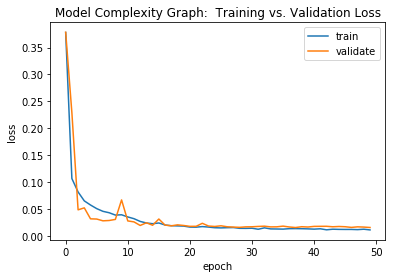

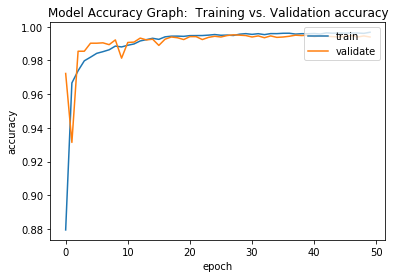

In [6]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Complexity Graph:  Training vs. Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.figure(2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy Graph:  Training vs. Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()



In [7]:
score = model.evaluate(x_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

4620/4620 [==============================] - 0s 68us/sample - loss: 0.0174 - acc: 0.9952
Loss: 0.0174
Accuracy: 0.9952


In [8]:
prediction=model.predict(x_test)
results=prediction
results = np.argmax(results,axis = 1)


results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)